In [1]:
import cv2
import numpy as np

In [2]:
# Setting up some constants
test_folder = "test_images"
calibration_folder = "camera_cal"

In [3]:
import glob
# Using glob to get list of files in folder
test_list = glob.glob(test_folder + '/*.jpg')
cal_list = glob.glob(calibration_folder + '/*.jpg')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

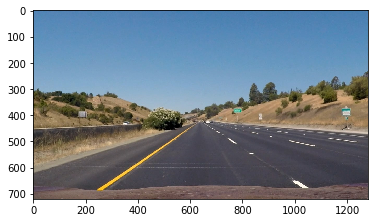

In [5]:
# Image example from test folder
lanes_image = mpimg.imread(test_list[2])
plt.imshow(lanes_image)

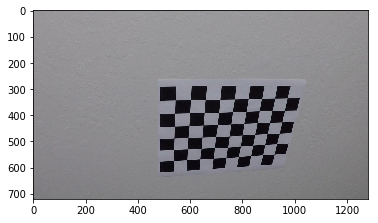

In [6]:
# Read and show distorted chessboard image from calibration folder
cb_image = mpimg.imread(cal_list[1])
plt.imshow(cb_image)

In [19]:
import ImageProcessing as IP

ret, mtx, dist, rvecs, tvecs = IP.get_camera_calibration(cal_list)

In [20]:
from utils import plot_2_images

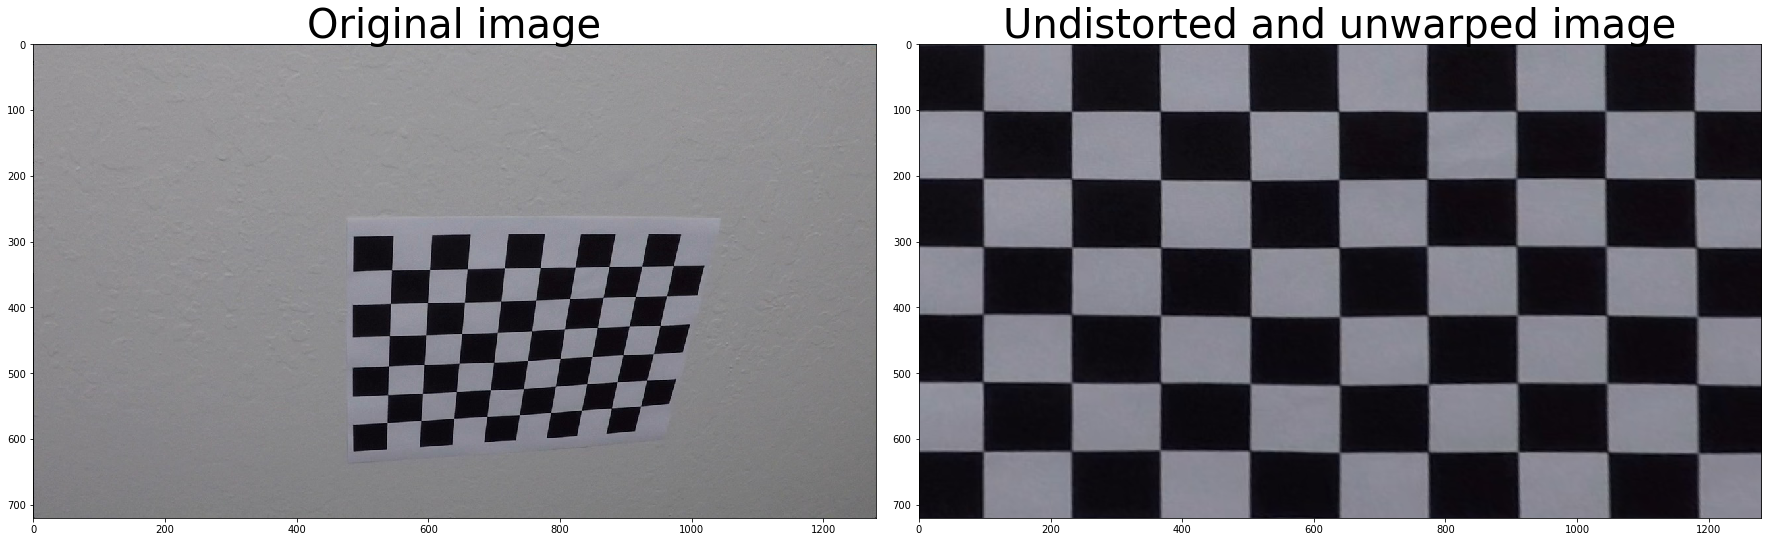

In [21]:
# Lets undistort and unwarp the image above
undist = cv2.undistort(cb_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
offset = 100
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
if ret == True:
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[9-1], corners[-1], corners[-9]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M_chess = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M_chess, img_size)
        plot_2_images(cb_image, warped, 'Original image', 'Undistorted and unwarped image')

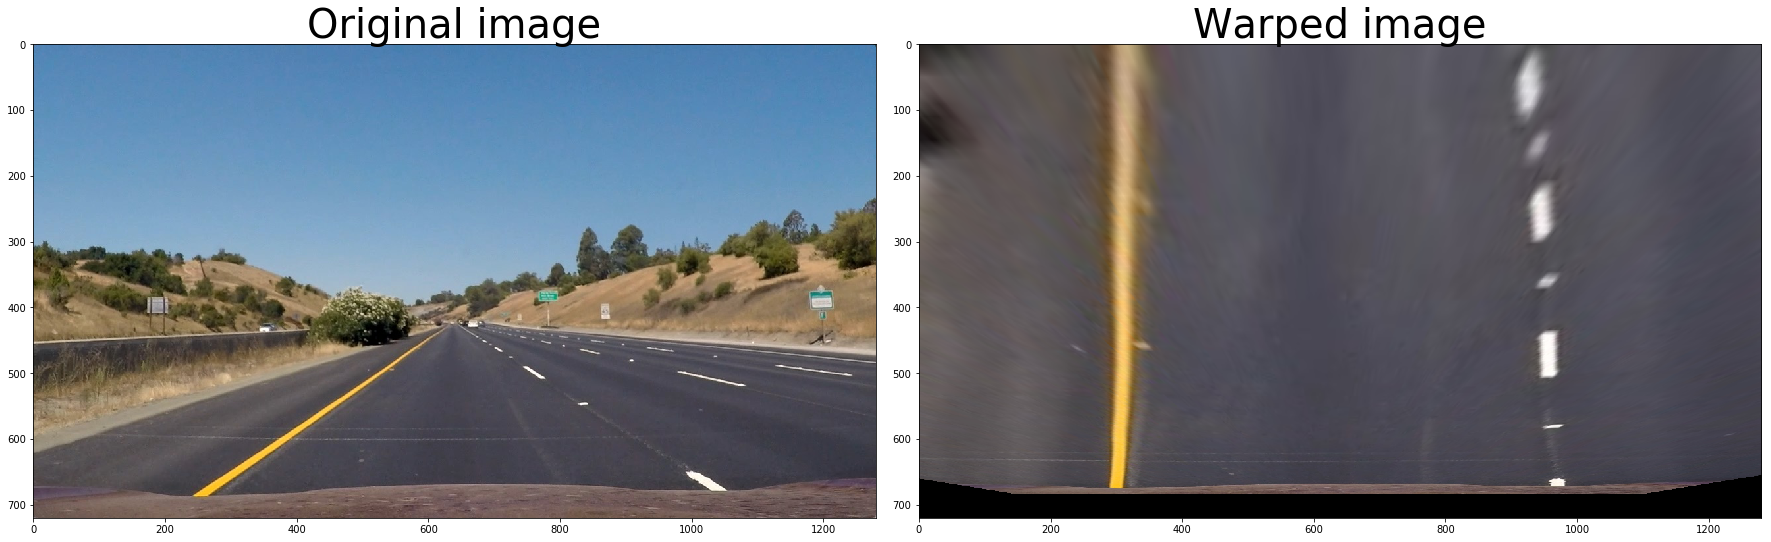

In [27]:
# Calculating perspective transormation Matrix
M, Minv = IP.get_perspective_transform_matrix()
warped_lanes = cv2.warpPerspective(lanes_image, M, (IP.IMG_SHAPE[0], IP.IMG_SHAPE[1]))
plot_2_images(lanes_image, warped_lanes, "Original image", "Warped image")

In [28]:
lanes_sob_abs_x = IP.abs_sobel_thresh(lanes_image, thresh_min=10, thresh_max=255)
lanes_sob_abs_y = IP.abs_sobel_thresh(lanes_image, thresh_min=10, thresh_max=255, orient='y')

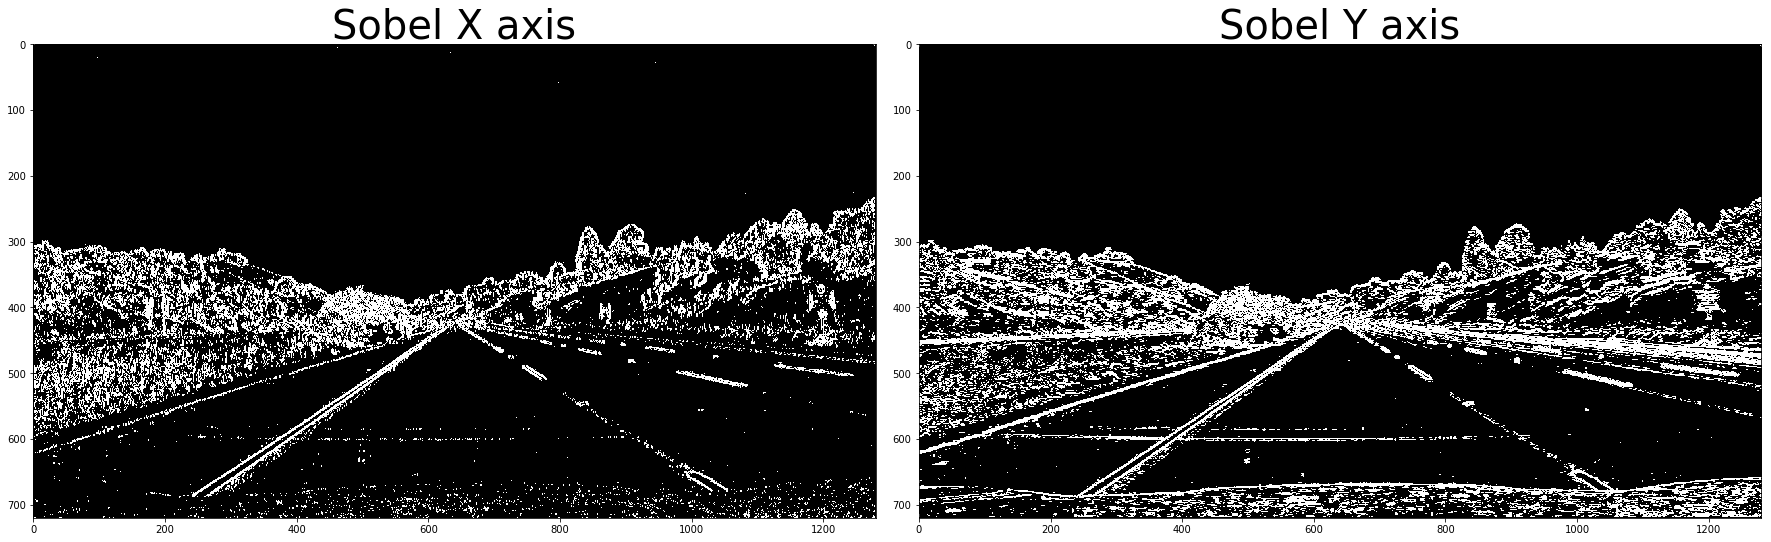

In [29]:
plot_2_images(lanes_sob_abs_x, lanes_sob_abs_y, 'Sobel X axis', 'Sobel Y axis')

In [30]:
sobel_mag = IP.mag_thresh(lanes_image, mag_thresh=(40, 255))
sobel_dir = IP.dir_threshold(lanes_image, thresh=(np.pi/8, np.pi/3))

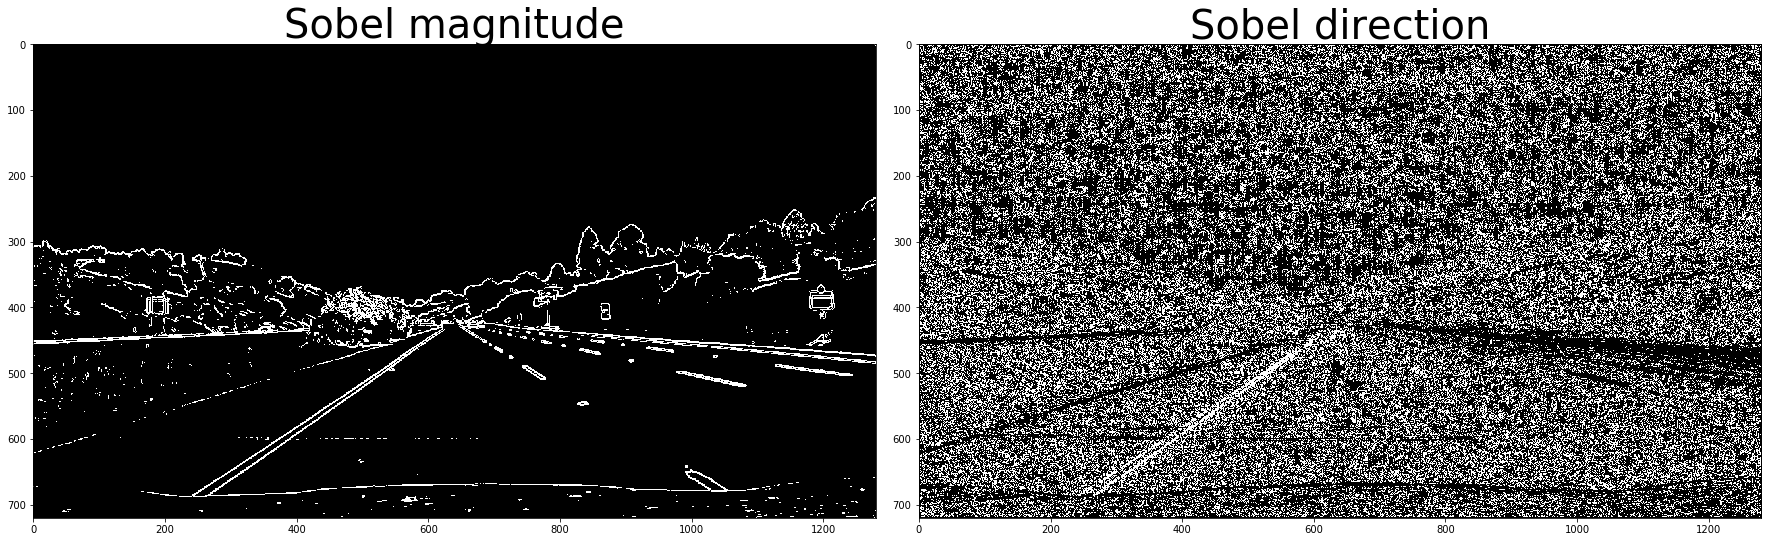

In [31]:
plot_2_images(sobel_mag, sobel_dir, 'Sobel magnitude', 'Sobel direction')

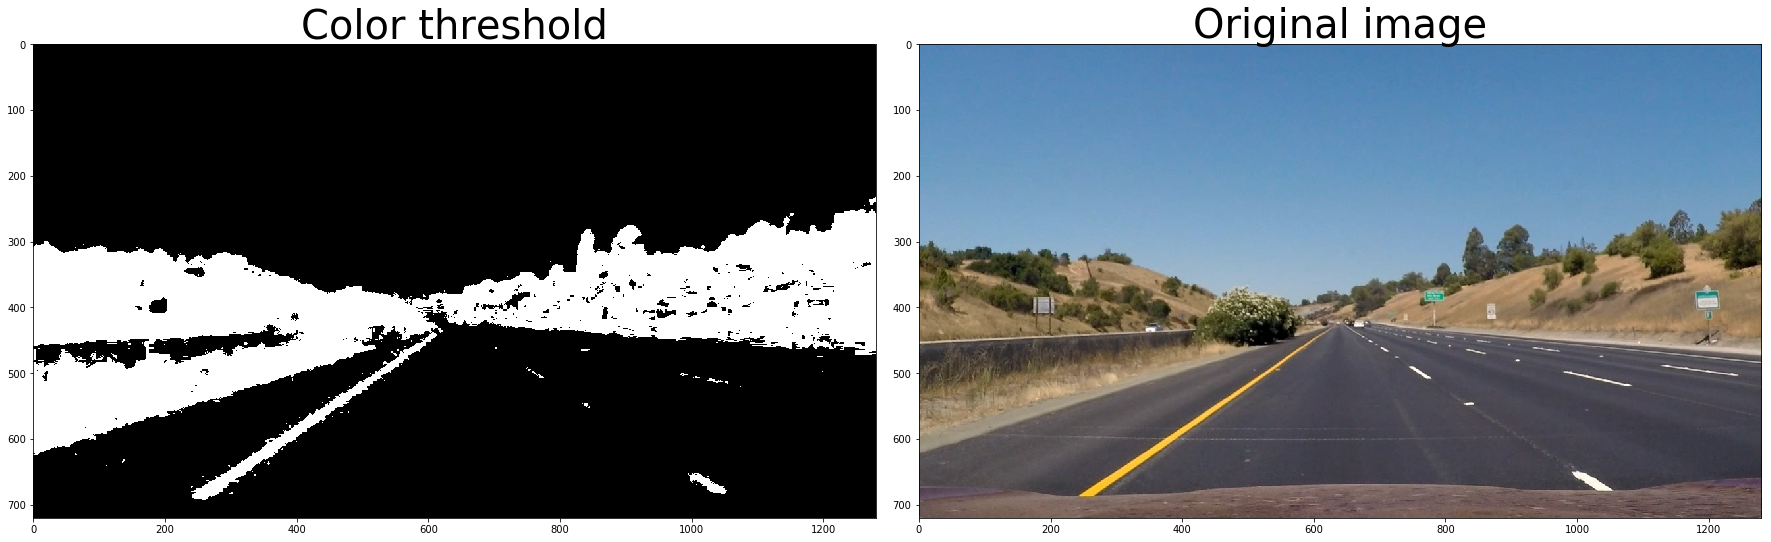

In [32]:
clr_thresh = IP.color_thresh(lanes_image)
plot_2_images(clr_thresh, lanes_image, 'Color threshold', 'Original image')

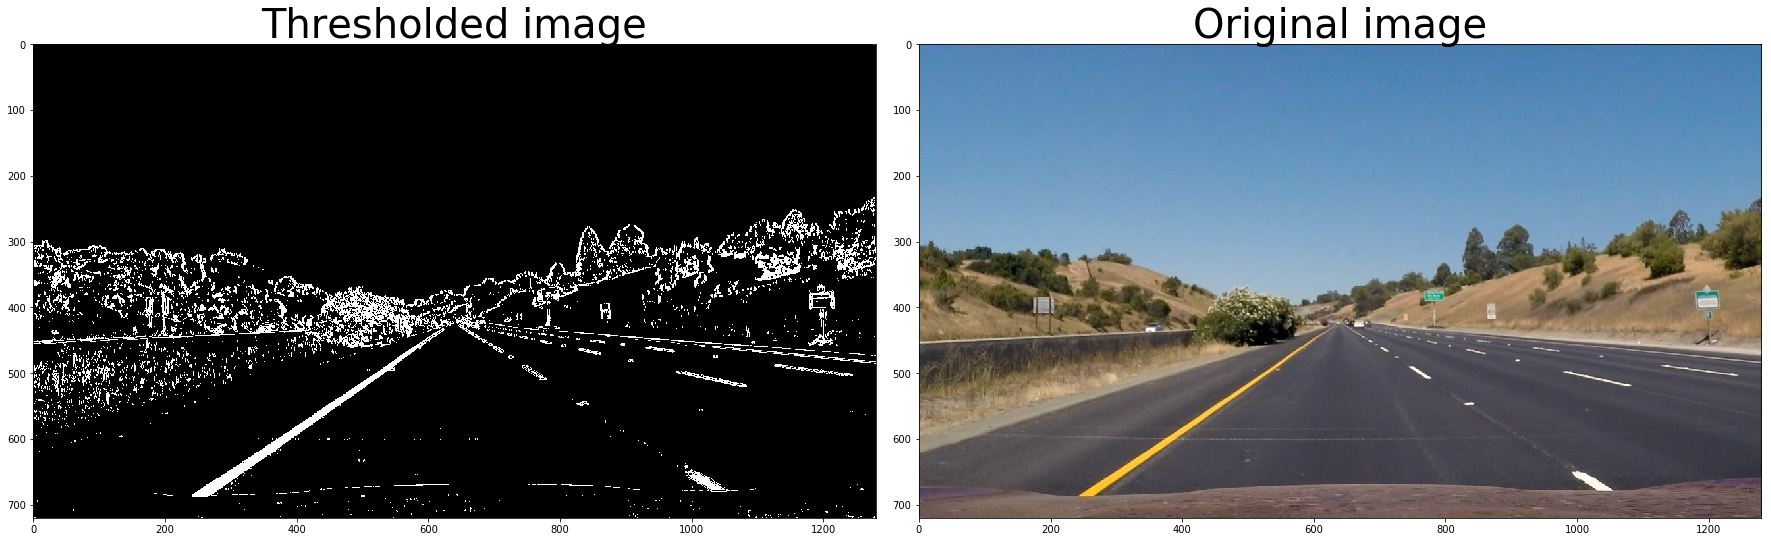

In [33]:
comb_lanes = IP.thresh_combined(lanes_image)
plot_2_images(comb_lanes, lanes_image, 'Thresholded image', 'Original image')

In [38]:
def pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    thr = IP.thresh_combined(undist)
    warped = cv2.warpPerspective(thr, M, (IP.IMG_SHAPE[0], IP.IMG_SHAPE[1]))
    return warped

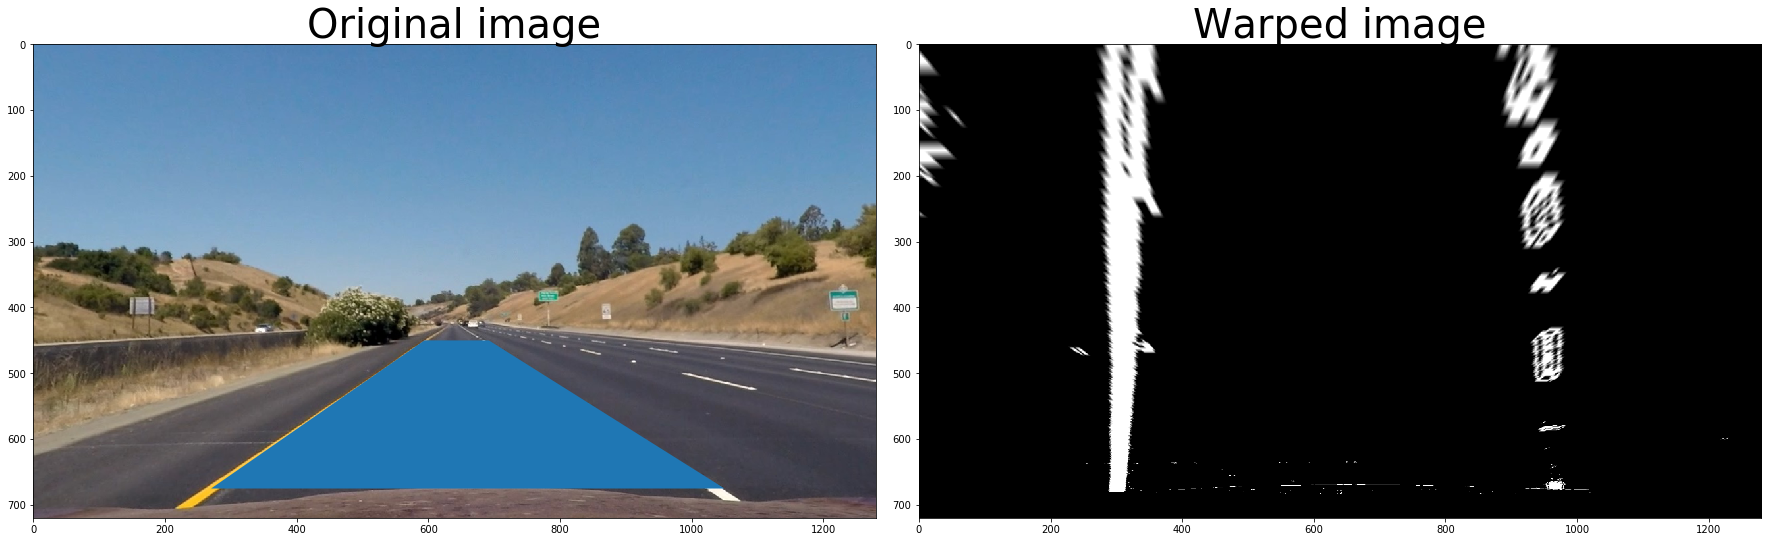

In [40]:
from matplotlib.patches import Polygon
undist = cv2.undistort(lanes_image, mtx, dist, None, mtx)
warped = pipeline(lanes_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist, cmap='gray')
ax1.set_title('Original image', fontsize=40)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped image', fontsize=40)
polygon = Polygon(IP.src, True)
ax1.add_patch(polygon)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

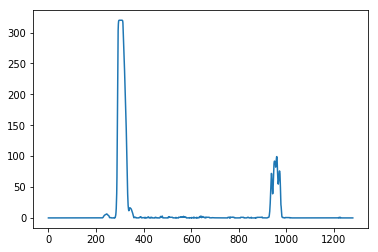

In [41]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [70]:
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.empty(3)
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [110]:
class Lane:
    
    NWINDOWS = 9
    MARGIN = 100
    MINPIX = 50
        
    def find_lines(self, img):
        warped = pipeline(img)
        leftx_base, rightx_base = self.get_line_base(warped)
        window_height = np.int(warped.shape[0]//self.NWINDOWS)
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        for window in range(self.NWINDOWS):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.MARGIN
            win_xleft_high = leftx_current + self.MARGIN
            win_xright_low = rightx_current - self.MARGIN
            win_xright_high = rightx_current + self.MARGIN
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),color=(0,255,0), thickness=2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),color=(0,255,0), thickness=2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.MINPIX:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.MINPIX:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract left and right line pixel positions
        self.left_lane.allx = nonzerox[left_lane_inds]
        self.left_lane.ally = nonzeroy[left_lane_inds] 
        self.right_lane.allx = nonzerox[right_lane_inds]
        self.right_lane.ally = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_lane.current_fit = np.polyfit(self.left_lane.ally, self.left_lane.allx, 2)
        self.right_lane.current_fit = np.polyfit(self.right_lane.ally, self.right_lane.allx, 2)
        
    def get_line_base(self, img):
        # Get starting X coordinates for left and rigth lanes
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        return leftx_base, rightx_base
    def draw_lane(self, img):
        warped = pipeline(img)
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = self.left_lane.current_fit[0]*ploty**2 + self.left_lane.current_fit[1]*ploty + self.left_lane.current_fit[2]
        right_fitx = self.right_lane.current_fit[0]*ploty**2 + self.right_lane.current_fit[1]*ploty + self.right_lane.current_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (IP.IMG_SHAPE[0], IP.IMG_SHAPE[1])) 
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        return result
    
    def __init__(self, img):
        self.left_lane = Line()
        self.right_lane = Line()
        self.find_lines(img)

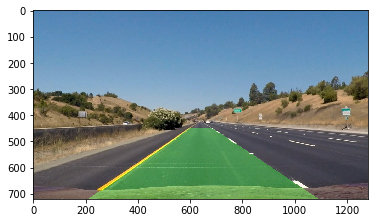

In [111]:
lane = Lane(lanes_image)
img = lane.draw_lane(lanes_image)
plt.imshow(img)

<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)
<class 'numpy.ndarray'> (720, 1280, 3)


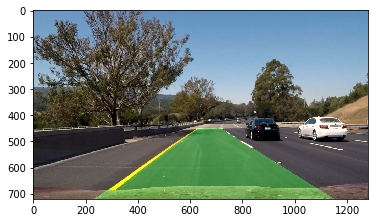

In [121]:
for img_name in test_list:
    image = mpimg.imread(img_name)
    lane = Lane(image)
    res = lane.draw_lane(image)
    print (type(res), res.shape)
    plt.imshow(res)
    mpimg.imsave("output_images/" + img_name.split('/')[-1], res, cmap='gray', format='jpg')

In [122]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [123]:
def process_image(image):
    lane = Lane(image)
    result = lane.draw_lane(image)
    return result

In [126]:
clip = VideoFileClip("project_video.mp4")
lane_clip = clip.fl_image(process_image) 
%time lane_clip.write_videofile('project_video_lanes.mp4', audio=False)

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████▉| 1260/1261 [08:06<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

CPU times: user 39min 47s, sys: 2.25 s, total: 39min 49s
Wall time: 8min 7s


In [10]:
import numpy as np
import cv2

cap = cv2.VideoCapture("project_video.mp4")
# Capture frame-by-frame
ret, frame = cap.read()
print(ret)
cv2.imshow('frame', frame)
cap.release()
cv2.destroyAllWindows()

False


error: /home/travis/miniconda/conda-bld/conda_1486587071158/work/opencv-3.1.0/modules/highgui/src/window.cpp:281: error: (-215) size.width>0 && size.height>0 in function imshow
